# Задание
- Применить метод К ближащих соседей (ядерный) с алгоритмом столб для 5 классов сгенерированных с помошью make_classification
- Для сгенерированного мной датасета построить профель компактности
- Для сгенерированного мной датасета произвести оптимезацию выбора ширены окна
- Найти сет с картинками, метод/библиотеку построения эмбединга картинок (векторизация), применить KNN для векторизованных картинок
- *На своих фотках проверить обученный KNN

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import optuna

import timm
import os



# Датасет

In [2]:
X, Y = make_classification(n_samples=1500, n_features=3, 
                           n_informative=3, n_classes=5, 
                           n_redundant=0,
                           n_clusters_per_class=1,
                           random_state=0)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=500, 
                                                    random_state=0)

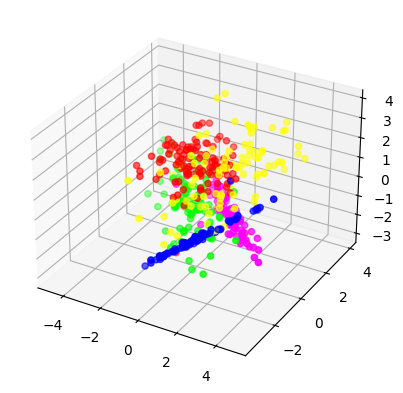

In [3]:
N = 500
colors = [np.array([1, 0, 0]).reshape(1,-1),np.array([0, 1, 0]).reshape(1,-1),np.array([0, 0, 1]).reshape(1,-1),
np.array([1, 1, 0]).reshape(1,-1),np.array([1, 0, 1]).reshape(1,-1),]
c = [colors[i] for i in Y_train[:N]]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[:N,0], X_train[:N,1], X_train[:N,2], c=c)
plt.show()

# Метод k-ближайших соседей

In [13]:
def Gaus(r): # гаусовское ядро
    return ((2 * np.pi)**(-1/2)) * np.exp(-1/2 * (r**2))
    
def KNeighbors(a, k, X_train, Y_train, h = 1, probability = False):
    # Сортировка по евклидовому расстоянию
    dtype = [('ind', int), ('y', int), ('distance', float)]
    ind = np.arange(len(Y_train))
    data = [(i, y, math.dist(a,x)) for i, x, y in zip(ind, X_train, Y_train)]
    data = np.array(data, dtype=dtype)
    data = np.sort(data, order=['distance'])

    # Собрать k соседей
    KNei = [[] for i in range(max(Y_train)+1)]
    for i in data:
        if len(KNei[i['y']]) < k:
            KNei[i['y']].append(i['distance'])
        # Остановка
        if sum(len(l) for l in KNei) == k * (max(Y_train)+1):
            break
    KNei = np.array(KNei)
    if not probability:
        # Вернуть argmax суммы гаусовских ядер от евклидового расстояния деленного на h
        return np.argmax(np.sum(Gaus(KNei/h), axis=1))
    else:
        return np.sum(Gaus(KNei/h), axis=1)

## Алгоритм STOLP для отбора эталонных объектов

In [5]:
def stolb(X_train, Y_train, N):
    data = [[] for i in range(max(Y_train)+1)]
    _, counts = np.unique(Y_train, return_counts=True)
    k = min(counts)
    for i in range(len(X_train)):
        t = KNeighbors(X_train[i], k, X_train, Y_train, h = 1, probability = True)
        data[np.argmax(t)].append((i,max(t)))

    for i, d in enumerate(data):
        dtype = [('ind', int), ('distance', float)]
        d = np.array(d, dtype=dtype)
        d = np.sort(d, order=['distance'])
        data[i] = d
    reference = [i[:N] for i in data]

    X_out, Y_out = [], []
    for i, d in enumerate(reference):
        for j, item in enumerate(d):
            X_out.append(X_train[item[0]])
            Y_out.append(i)
    return np.array(X_out), np.array(Y_out)
    
    

In [6]:
X_stolb, Y_stolb = stolb(X_train, Y_train, 500)

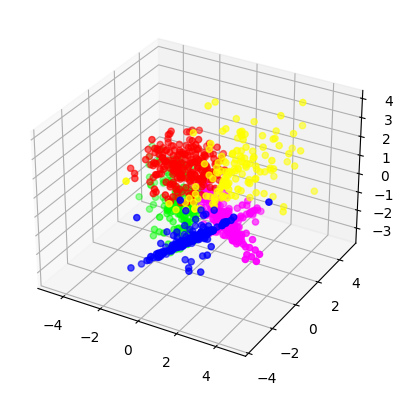

In [7]:
c = [colors[i] for i in Y_stolb]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_stolb[:,0], X_stolb[:,1], X_stolb[:,2], c=c)
plt.show()

## Поиск оптимального k

График заыисимости acc от K


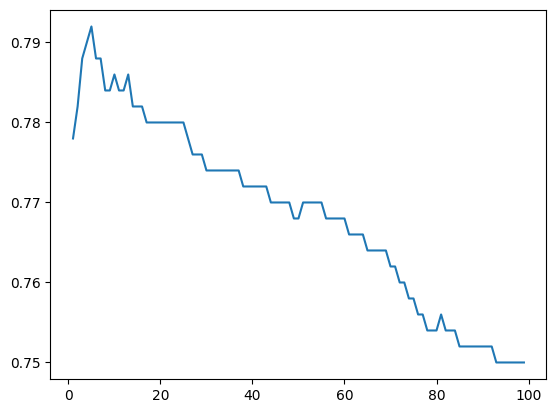

Оптимальный acc = 0.792 , при k = 4


In [8]:
def score(X_test, Y_test, k, X_train, Y_train, h = 1):
    s = [KNeighbors(x, k, X_train, Y_train, h = h) == y for x, y in zip(X_test, Y_test)]
    return sum(s)/len(s)
    
scores = []
for i in range(1,100):
    scores.append(score(X_test, Y_test, i, X_stolb, Y_stolb))
print("График заыисимости acc от K")
plt.plot(range(1,100), scores)
plt.show()
k = scores.index(max(scores))
print("Оптимальный acc =", max(scores), ", при k =",k)

# Профиль компактности

Профиль компактности на всем train


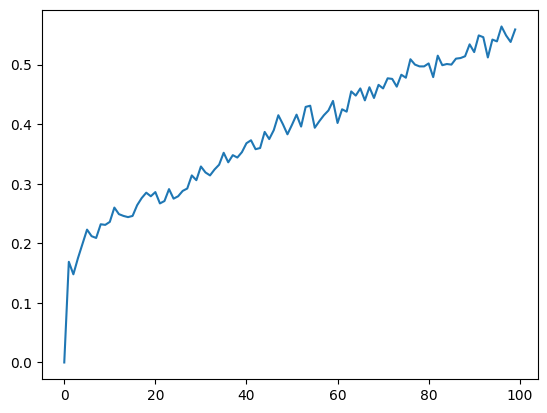

In [11]:
N = 100
R = []
for j in range(N):
    R_j = 0
    for x_i, y_i in zip(X_train, Y_train):
        dtype = [('y', int), ('distance', float)]
        ind = np.arange(len(Y_train))
        data = [(y, math.dist(x_i,x)) for x, y in zip(X_train, Y_train)]
        data = np.array(data, dtype=dtype)
        data = np.sort(data, order=['distance'])
        R_j += data[j]['y'] != y_i
    R.append(R_j / len(Y_train))

print("Профиль компактности на всем train")
plt.plot(range(100), R)
plt.show()

Профиль компактности на эталонных обьектах


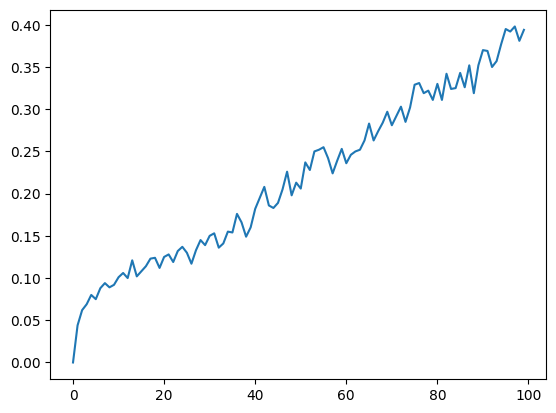

In [12]:
N = 100
R = []
for j in range(N):
    R_j = 0
    for x_i, y_i in zip( X_stolb, Y_stolb):
        dtype = [('y', int), ('distance', float)]
        ind = np.arange(len(Y_stolb))
        data = [(y, math.dist(x_i,x)) for x, y in zip(X_stolb, Y_stolb)]
        data = np.array(data, dtype=dtype)
        data = np.sort(data, order=['distance'])
        R_j += data[j]['y'] != y_i
    R.append(R_j / len(Y_stolb))

print("Профиль компактности на эталонных обьектах")
plt.plot(range(100), R)
plt.show()

# Оптимезация выбора ширены окна

In [34]:
k = 4
def objective(trial):
    h = trial.suggest_float("h", 0.01, 100, log=True)
    return 1 / score(X_test, Y_test, k, X_stolb, Y_stolb, h)

optuna.logging.disable_default_handler() #Отключить логирование
study = optuna.create_study()
study.optimize(objective, n_trials=400)

best_params = study.best_params
found_h = best_params["h"]
print("###### Результат ######")
print("Найденное    h: {:0.3f}, acc(h): {:0.3f}".format(found_h, score(X_test, Y_test, k, X_stolb, Y_stolb, found_h)))

###### Результат ######
Найденное    h: 0.406, acc(h): 0.792


In [ ]:
import optuna

def objective(trial):
    h = trial.suggest_float("h", 0, 100)
    return 1 / score(X_test, Y_test, k, X_stolb, Y_stolb, h)

optuna.logging.disable_default_handler() #Отключить логирование
study = optuna.create_study()
study.optimize(objective, n_trials=400)

best_params = study.best_params
found_h = best_params["h"]
print("###### Результат ######")
print("Найденное    h: {:0.3f}, acc(h): {:0.3f}".format(found_h, score(X_test, Y_test, k, X_stolb, Y_stolb, found_h)))

# Применение KNN для векторизованных картинок

## Weather Image Recognition содержит 11 классов и 6862 изображения типов погоды

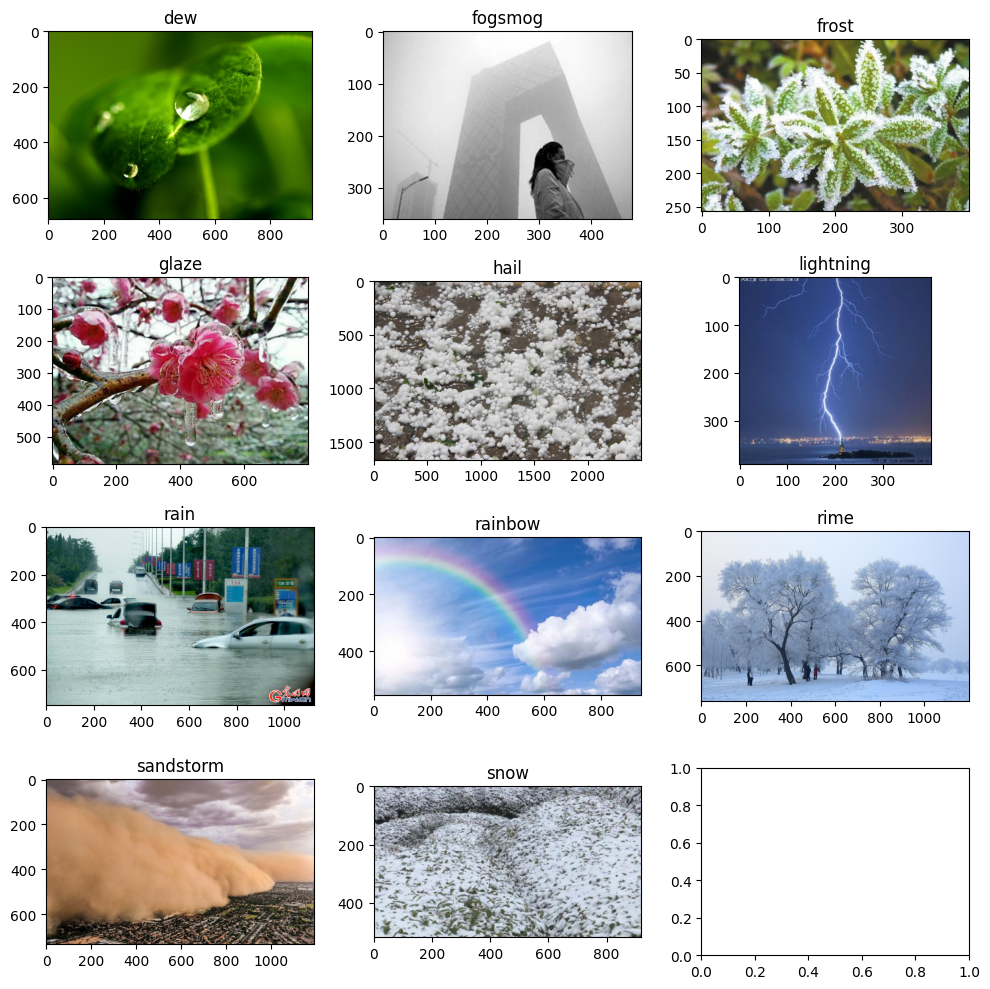

In [5]:
data_sors = "../datasets/Weather_Image_Recognition"
clas = os.listdir(data_sors)
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))
for i, c in enumerate(clas):
    image_pat = data_sors + "/" + c +  "/" + os.listdir(data_sors + "/" + c)[0]
    image = plt.imread(image_pat)
    axs.flat[i].imshow(image)
    axs.flat[i].set_title(c)
plt.tight_layout()
plt.show()

## Энбэдинг обученным resnet18 на Imagenet

In [10]:
import albumentations as A
import albumentations.pytorch as Ap
import cv2

model = timm.create_model("resnet18", pretrained=True)
model = model.eval()
X_image = []
Y_image = []
val_transforms = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        Ap.transforms.ToTensorV2()
        ])
k = 0
for i, c in enumerate(clas):
    for j in os.listdir(data_sors + "/" + c):
        k+=1
        try:
            image = cv2.imread(data_sors + "/" + c + "/" + j)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = val_transforms(image=image)["image"]
            X_image.append(model(image.unsqueeze(0)).detach().numpy()[0])
            Y_image.append(i)
        except:
            print(data_sors + "/" + c + "/" + j)

../datasets/Weather_Image_Recognition/fogsmog/4514.jpg
../datasets/Weather_Image_Recognition/snow/1187.jpg


# Проверка обученного KNN на своих фотках

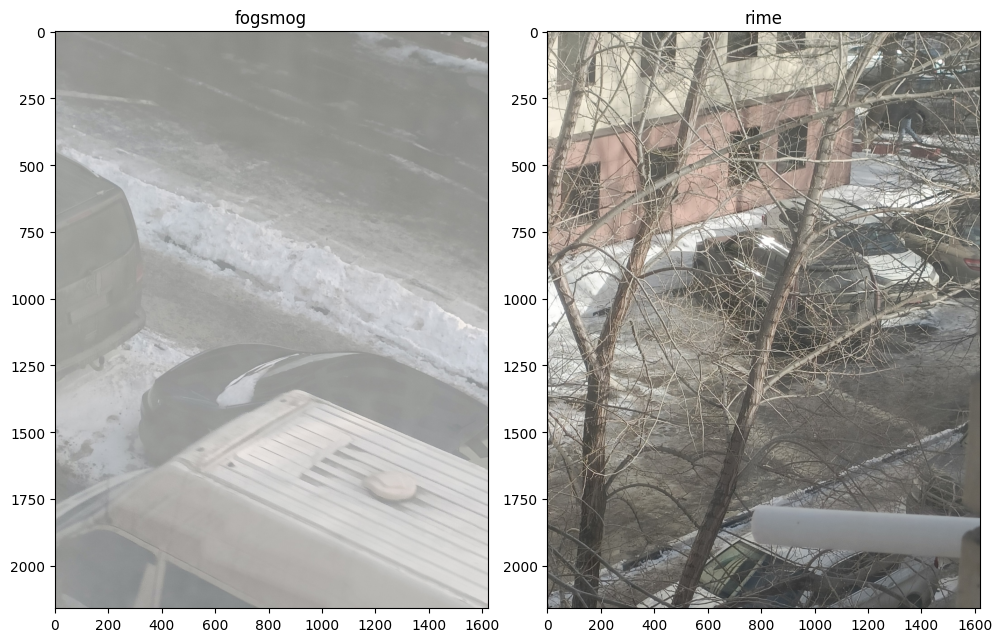

In [49]:
data_sors = "../datasets/test"
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
k = 100
h = 50
X_image_test = []
Y_image_test = []
val_transforms = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        Ap.transforms.ToTensorV2()
        ])
for i, j in enumerate(os.listdir(data_sors)):
    image_pat = data_sors + "/" + j
    image = plt.imread(image_pat)
    axs.flat[i].imshow(image)
    image = cv2.imread(image_pat)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = val_transforms(image=image)["image"]
    axs.flat[i].set_title(clas[KNeighbors(model(image.unsqueeze(0)).detach().numpy()[0], k, X_image, Y_image, h)])
plt.tight_layout()
plt.show()